In [1]:
import torchvision as thv
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)
print(train.data.shape, len(train.targets))
print(val.data.shape, len(val.targets))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

torch.Size([60000, 28, 28]) 60000
torch.Size([10000, 28, 28]) 10000


The sampled labels in training data is:  [tensor([0]), tensor([1]), tensor([2]), tensor([3]), tensor([4]), tensor([5]), tensor([6]), tensor([7]), tensor([8]), tensor([9])]
The sampled labels in validation data is:  [tensor([0]), tensor([1]), tensor([2]), tensor([3]), tensor([4]), tensor([5]), tensor([6]), tensor([7]), tensor([8]), tensor([9])]


<Figure size 720x576 with 0 Axes>

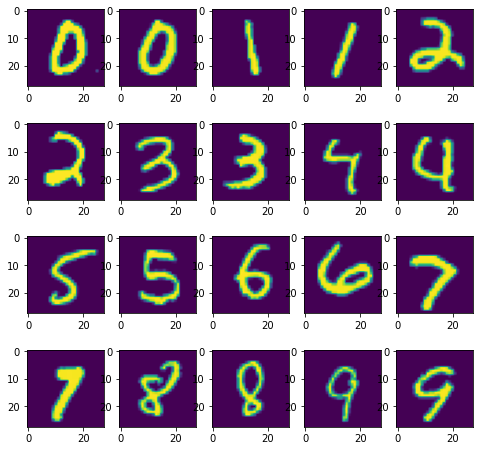

In [53]:
# sample a smaller dataset 
from random import sample
import matplotlib.pyplot as plt
train_idx = []
val_idx = []
fig1 = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Label Check")
train_sample_idx = []
val_sample_idx = []
fig = plt.figure(figsize=(8,8))
for i in range(10):
  y_train_i = [e for e in range(len(train.targets)) if train.targets[e]==i]
  y_val_i = [e for e in range(len(val.targets)) if val.targets[e]==i]

  y_train_idx = sample(y_train_i, int(len(y_train_i)/2))
  y_val_idx = sample(y_val_i, int(len(y_val_i)/2))
  train_idx.extend(y_train_idx)
  val_idx.extend(y_val_idx)

  #plot to examine
  check_train_idx = sample(y_train_idx,1)
  train_sample_idx.append(check_train_idx)
  check_val_idx = sample(y_val_idx,1)
  val_sample_idx.append(check_val_idx)
  train_sample = train.data[check_train_idx].reshape((28,28))
  val_sample = val.data[check_val_idx].reshape((28,28))
  plt.subplot(4, 5, 2*i+1)
  plt.imshow(train_sample)
  plt.subplot(4, 5, 2*i+2)
  plt.imshow(val_sample)
fig.savefig("Label Check.pdf")
  

print("The sampled labels in training data is: ", [train.targets[i] for i in train_sample_idx])
print("The sampled labels in validation data is: ", [val.targets[i] for i in val_sample_idx])

x_train = train.data[train_idx]
x_val = val.data[val_idx]
y_train = train.targets[train_idx]
y_val = val.targets[val_idx]

(b) 

In [37]:
import numpy as np

class linear_t:
  def __init__(self,input_size,output_size):
  # initialize to appropriate sizes, fill with Gaussian entires
  # normalize to make the Frobenius norm of w, b equal to 1
    self.w = np.random.normal(0.5, 0.5, (output_size, input_size))
    self.w = self.w/np.linalg.norm(self.w, ord='fro')
    self.b = np.random.rand(1,output_size)
    self.b = self.b/np.linalg.norm(self.b,ord='fro')
    self.dw = 0
    self.db = 0

  def forward(self, h_L):
    self.h_L = h_L
    # h_{i+1}
    self.h_L1 = np.dot(self.h_L,np.transpose(self.w))+self.b
    # cache h^l in forward because we will need it to compute
    # dw in backward
    return self.h_L1
  
  def backward(self, dh_L1):
    dh_L = np.dot(dh_L1,self.w)
    dw = np.dot(np.transpose(dh_L1),self.h_L)
    db = dh_L1
    self.dw, self.db = dw, db
    # notice that there is no need to cache dh^l
    return dh_L
  
  def zero_grad(self):
    # useful to delete the stored backprop gradients of the
    # previous mini-batch before you start a new mini-batch
    self.dw, self.db = 0*self.dw, 0*self.db

(c)

In [33]:
class relu_t:
  def __init__(self):
    self.h_L = None

  def forward(self, h_L):
    self.h_L = h_L
    return np.maximum(0, h_L)
  
  def backward(self, dh_L1):
    dz = dh_L1.copy()
    dz[self.h_L<=0] = 0
    return dz
  
  def zero_grad(self):
    # useful to delete the stored backprop gradients of the
    # previous mini-batch before you start a new mini-batch
    self.h_L = 0

(d)

In [34]:
from numpy.matrixlib.defmatrix import N
class softmax_cross_entropy_t:
  def __init__(self):
  # no parameters , nothing to initialize
    self.h_L1 = None
    self.dh_L = 0
  def forward(self, h_L, y):
    n = h_L.shape[0]
    h_L1 = np.exp(h_L)/np.sum(np.exp(h_L),axis=0)
    self.h_L1 = h_L1
    # compute average loss ell(y) over a mini-batch
    ell = -1/n*np.sum(np.log(h_L1),axis=1)
    y_pred = np.argmax(-np.log(h_L1),axis=1)
    
    e = y != y_pred
    e.astype(int)
    error = 1/n*np.sum(e)
    return ell, error

  def backward(self):
    # as we saw in the notes, the backprop input to the
    # loss layer is 1, so this function does not take any
    # arguments
    n = self.h_L1.shape[0]
    k = self.h_L1.shape[1]
    dh_L1 = -1/(self.h_L1*n)
    temp = -np.dot(self.h_L1.T,self.h_L1)
    add = np.zeros((k, n))
    np.fill_diagonal(add, np.ones(k))
    grad_dL= temp + np.dot(add,self.h_L1)
    dh_L = np.dot(dh_L1, grad_dL)
    return dh_L
  def zero_grad(self):
    # useful to delete the stored backprop gradients of the
    # previous mini-batch before you start a new mini-batch
    self.dh_L = 0*self.dh_L

(e)

In [35]:
# tensor to numpy array
x_train_np = x_train.numpy()
x_val_np = x_val.numpy()
y_train_np = y_train.numpy()
y_val_np = y_val.numpy()

In [42]:
# linear layer
import random
l1 = linear_t(784,10)
h_L = x_train_np[0].reshape((1,784))
h_L = h_L/np.sum(h_L)
print(h_L.shape)
h_L1 = l1.forward(h_L)
d_L1 = np.zeros((1,10))
perturb = np.zeros((10,784))
entry = np.random.normal(0,1,1)
# difference between the calculated dw and estimation
comp = []
for k in range(5):
  d_L1[0][k] = 1
  dh_L = l1.backward(d_L1)
  for j in range(10):
    r = random.randint(0,9)
    c = random.randint(0,783)
    perturb[r][c] = entry
    dw_est = np.dot(h_L,(l1.w + perturb).T)[0][k]-np.dot(h_L,(l1.w - perturb).T)[0][k]/2*entry
    comp.append(l1.dw[r][c] - dw_est)
max(comp)


(1, 784)


array([-0.00145944])

In [43]:
# relu layer
l2 = relu_t()
h_L = x_train_np[0].reshape((1,784))
h_L = h_L/np.sum(h_L)
h_L1 = l2.forward(h_L)
d_L1 = np.zeros((1,784))
perturb = np.zeros((1,784))
entry = np.random.normal(0,1,1)
# difference between the calculated dh_L and estimation
comp = []
for k in range(5):
  d_L1[0][k] = 1
  dz = l2.backward(d_L1)
  for j in range(10):
    c = random.randint(0,783)
    perturb[0][c] = entry
    dz_est = np.maximum(h_L+perturb,0)[0][k]-np.maximum(h_L-perturb,0)[0][k]/2*entry
    comp.append(dz[0][c] - dz_est)
max(comp)


array([0.])

In [44]:
# softmax_cross_entropy
l3 = softmax_cross_entropy_t()
h_L = x_train_np[0].reshape((1,784))
h_L = h_L/np.sum(h_L)
y = y_train_np[0]
ell, err = l3.forward(h_L,y)
d_L1 = np.zeros((1,784))
perturb = np.zeros((1,784))
entry = np.random.normal(0,1,1)
# difference between the calculated dh_L and estimation
comp = []
for k in range(5):
  d_L1[0][k] = 1
  dz = l3.backward()
  for j in range(10):
    c = random.randint(0,783)
    perturb[0][c] = entry
    dh_L_est = np.exp(h_L+perturb)[0][k]/np.sum(np.exp(h_L+perturb),axis=1)-np.exp(h_L-perturb)[0][k]/np.sum(np.exp(h_L-perturb),axis=1)/2*entry
    comp.append(l3.dh_L - dh_L_est)
max(comp)



array([-0.00172473])

(f)

流式输出内容被截断，只能显示最后 5000 行内容。
(32, 10)
4375 [1.0830249  1.08307672 1.08309077 1.08314115 1.08304016 1.0830259
 1.08305726 1.0830856  1.08304157 1.08309071 1.08303924 1.08299791
 1.0830507  1.08299766 1.08298209 1.08304142 1.08304736 1.08304553
 1.08302424 1.08294495 1.08301371 1.08320118 1.0831453  1.08296705
 1.08302681 1.08298144 1.08298149 1.08301125 1.08311723 1.08316987
 1.08296746 1.08293253] 0.9375
4375 1.1013591253075046 0.006867410161334302
(32, 10)
4376 [1.08299324 1.0830459  1.08307202 1.08317463 1.08306322 1.08305967
 1.08298736 1.08306875 1.08304891 1.08299197 1.08296789 1.08298066
 1.08318896 1.08297654 1.083115   1.08307269 1.08302238 1.08299588
 1.08309273 1.08304326 1.08301601 1.08314383 1.08306876 1.08294737
 1.08305387 1.08302295 1.08303357 1.08302586 1.08298632 1.08303869
 1.08295853 1.08310365] 0.875
4376 0.3657455272549747 0.0027590551869675272
(32, 10)
4377 [1.08295933 1.08310089 1.08297454 1.08308221 1.08299893 1.08296259
 1.08304987 1.08311388 1.08296831 1.083122 

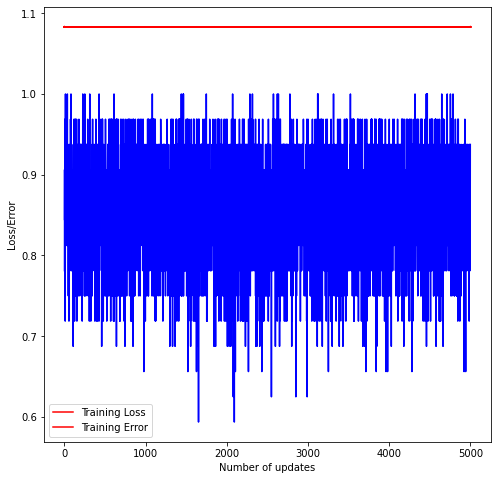

In [41]:
# load dataset
# initialize all the layers
from sklearn.preprocessing import normalize
l1, l2, l3 = linear_t(784,10), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]
lr = 0.1
loss = []
err = []
for t in range(5000):
  batch_idx = random.sample(range(x_train_np.shape[0]),32)
  x_tr = x_train_np[batch_idx].reshape(32, -1)
  x_tr = normalize(x_tr, axis=1, norm='l1')
  y_tr = y_train_np[batch_idx]

  for l in net:
    l.zero_grad()
 
  h1 = l1.forward(x_tr)
  h2 = l2.forward(h1)
  print(h2.shape)
  
  ell, error = l3.forward(h2, y_tr)
  loss.append(ell)
  err.append(error)

  dh2 = l3.backward()
  dh1 = l2.backward(dh2)
  dx = l1.backward(dh1)

  dw, db = l1.dw, l1.db

  print(t, ell, error)
  print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))

  l1.w = l1.w-lr*dw
  l1.b = l1.b-lr*db
plt.figure(figsize=(8,8))
plt.plot(list(range(5000)),loss, 'r')
plt.plot(list(range(5000)),err, 'b')
plt.xlabel('Number of updates')
plt.ylabel('Loss/Error')
plt.legend(['Training Loss','Training Error'])
plt.show()
